In [1]:
import os, spacy, gzip, rltk, gzip, random, os
import torch
from tqdm import tqdm
from collections import defaultdict
import networkx as nx
from numpy import dot
from numpy.linalg import norm
import numpy as np
from sentence_transformers import SentenceTransformer
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [23]:
input_dir='input'
wordnet_file="%s/kgtk_wordnet.tsv" % input_dir
cskg_embeddings_file="%s/bert_embeddings.txt" % input_dir
cskg_tranE_file="%s/trans_log_dot_0.1.tsv.gz" % input_dir
cskg_complex_file='%s/comp_log_dot_0.1.tsv.gz' % input_dir
cskg_file="%s/cskg_renamed.tsv.gz" % input_dir

## Data Preparation
load data model, embedding file, and black list (takes 10 mins, grab a coffee)

In [4]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/filipilievski/nltk_data...


True

In [5]:
# sentence transformer model
model = SentenceTransformer('nli-bert-large')
# nlp model
nlp = spacy.load("en_core_web_sm")
# sentiment model
sia = SentimentIntensityAnalyzer()

Some weights of the model checkpoint at /Users/filipilievski/.cache/torch/sentence_transformers/sbert.net_models_nli-bert-large/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def text2token(text):
    doc=nlp(text)
    for sent in doc.sents:
        break
        
    return list(sent)

def load_source(filename):
    # load data
    with open(filename,"r",encoding="utf-8") as f:
        head=f.readline().strip().split("\t")
        data=[]
        for line in f:
            temp=line.strip().split("\t")
            data.append([item.split("|")[0] for item in temp])
            
    return head, data

def cosine_similar(embed1, embed2):
    similar=dot(embed1, embed2)/(norm(embed1)*norm(embed2))
    return similar

# load cskg embedding file
def load_embedding():
    with open(cskg_embeddings_file,"r") as f:
        head= f.readline().strip().split("\t")

        # obtain embedding_sentence in file
        cskg_word_embeddings=dict()

        for item in tqdm(f):
            # obtain list of line
            line=item.strip().split("\t")

            # only property is text embedding can obtain embeddings
            word=line[0]
            prop=line[1]
            embedding=line[2]

            if prop=="text_embedding":
                cskg_word_embeddings[word]=embedding
    return cskg_word_embeddings

# load complex and tranE file
def load_embedding_gz(filename):
    cskg_word_embeddings=dict()
    f=gzip.open(filename,'rb')
    
    for item in tqdm(f):
        # obtain list of line
        line=item.strip().decode("utf-8").split("\t")
        word=line[0]
        embed=np.array([float(_) for _ in line[2:]])
        cskg_word_embeddings[word]=embed
        
    return cskg_word_embeddings

def synsets_cosine_sim(label1, label2):
    # find the highest cosine similarity between two label by synsets definition
    syns1=wn.synsets(label1.replace(" ","_"))
    syns2=wn.synsets(label2.replace(" ","_"))
    
    sents1=[]
    sents2=[]
    
    for syn in syns1:
        sent=syn.definition()
        sents1.append(sent)
        
    for syn in syns2:
        sent=syn.definition()
        sents2.append(sent)
        
    sents1_embed=model.encode(sents1)
    sents2_embed=model.encode(sents2)
    max_sim=0
    
    for embed1 in sents1_embed:
        for embed2 in sents2_embed:
            sim=cosine_similar(embed1,embed2)
            max_sim=max(max_sim,sim)
            
    return max_sim

def find_sent(sent_target, items):
    for item in items:
        sent_candit=item[0]
        
        if sent_candit==sent_target:
            return item
        
def prediction_check(predict_score, threshold, ground):
    if predict_score>threshold:
        predict="1"
    else:
        predict="0"
        
    return predict==ground

In [7]:
# embedding file
cskg_tranE_embedding=load_embedding_gz(cskg_tranE_file)
cskg_complex_embedding=load_embedding_gz(cskg_complex_file)

2160968it [01:15, 28493.80it/s]
2160968it [01:21, 26573.84it/s]


In [24]:
cskg_word_embeddings=load_embedding()

4322096it [00:42, 101251.85it/s]


In [10]:
# build wordnet ontology
# load wordnet
# use wordnet build ontology to find blacklist related to person and animal
wordnet_head,wordnet_lines=load_source(wordnet_file)
wordnet_g=nx.DiGraph()

id2label=defaultdict(set)
#black_list={"room.n.02",'room.n.01',"food.n.01",'animal.n.01','person.n.01',"people.n.01","peoples.n.01"}
black_list={'animal.n.01','person.n.01',"people.n.01","peoples.n.01"}
for line in wordnet_lines:
    if line[1]== "/r/IsA":
        node1=line[0].split(":")[1]
        node2=line[2].split(":")[1]
        node1_labels=line[3].replace('"',"").split("|")
        node2_labels=line[4].replace('"',"").split("|")
        id2label[node1]=id2label[node1].union(node1_labels)
        id2label[node2]=id2label[node2].union(node2_labels)
        
        if ".v." in node1 or ".v." in node1:
            continue
        wordnet_g.add_edge(node1,node2)
    else:
        continue
        
new_black_list=set()
# check all sub class of blacklist

for item in black_list:
    temp=[item]
    new_black_list.add(item)
    while temp:
        new_temp=[]
        for issue in temp:
            new_temp+=[edge[0] for edge in wordnet_g.in_edges(issue)]
            
        new_temp_set=set(new_temp)
        new_black_list=new_black_list.union(new_temp_set)
        temp=new_temp_set
        
# check the blacklist label
blacklist_label=set()

for id_ in new_black_list:
    blacklist_label=blacklist_label.union(id2label[id_])
    
blacklist_label.add("human")

In [12]:
len(blacklist_label)

10219

In [15]:
len(new_black_list)

11117

In [21]:
# example of blacklist_label
# check whether girl in blacklist

"girl" in blacklist_label

True

In [18]:
# load cskg_renamed file
with gzip.open(cskg_file) as f:

    head=f.readline()
    cskg_renamed_dist=dict()
    for line in f:
        line=line.strip().decode("utf-8").split("\t")
        node1=line[1]
        node2=line[3]

        node1_label=line[4].split("|")[0].replace('"','')
        node2_label=line[5].split("|")[0].replace('"','')
        if node1_label != "":
            cskg_renamed_dist[node1]=node1_label

        if node2_label != "":
            cskg_renamed_dist[node2]=node2_label

## Case 2: Alternatives

I went to the (Y) and I wanted to (X). There was no (Z), can I use (C) instead?

In [32]:
# data file location

data_part1="output/case2_1.gz"
data_part2="output/case2_2.gz"

case2_cskg_file="output/case2_cskg.txt"
case2_bert_file="output/case2_bert.txt"
case2_tranE_file="output/case2_tranE.txt"
case2_complex_file="output/case2_complex.txt"

case2_cskgFFN_file=".output/case2_cskg_FFN.txt"
case2_bertFFN_file="output/case2_bert_FFN.txt"
case2_tranEFFN_file="output/case2_tranE_FFN.txt"
case2_complexFFN_file="output/case2_complex_FFN.txt"

case2_ground="./ground/case2_ground.tsv"

In [29]:
%%bash
kgtk query --debug -i input/cskg_renamed.tsv.gz --match '(x)<-[:`/r/CapableOf`]-(z)-[:`/r/AtLocation`]->(y)<-[:`/r/AtLocation`]-(c)-[:`/r/CapableOf`]->(x)' --where 'c!=z' --return 'z as plan, c as alt, x as goal, y as loc' -o output/case2_1.gz
kgtk query --debug -i input/cskg_renamed.tsv.gz --match '(x)<-[:`/r/UsedFor`]-(z)-[:`/r/AtLocation`]->(y)<-[:`/r/AtLocation`]-(c)-[:`/r/UsedFor`]->(x)' --where 'c!=z' --return 'z as plan, c as alt, x as goal, y as loc' -o output/case2_2.gz

[2021-05-26 09:49:07 sqlstore]: IMPORT graph directly into table graph_1 from /Users/filipilievski/mcs/kg-bert/GameSentence/input/cskg_renamed.tsv.gz ...
[2021-05-26 09:50:16 query]: SQL Translation:
---------------------------------------------
  SELECT graph_1_c1."node1" "_aLias.plan", graph_1_c4."node1" "_aLias.alt", graph_1_c1."node2" "_aLias.goal", graph_1_c3."node2" "_aLias.loc"
     FROM graph_1 AS graph_1_c1, graph_1 AS graph_1_c2, graph_1 AS graph_1_c3, graph_1 AS graph_1_c4
     WHERE graph_1_c1."label"=?
     AND graph_1_c2."label"=?
     AND graph_1_c3."label"=?
     AND graph_1_c4."label"=?
     AND graph_1_c1."node1"=graph_1_c2."node1"
     AND graph_1_c1."node2"=graph_1_c4."node2"
     AND graph_1_c2."node2"=graph_1_c3."node2"
     AND graph_1_c3."node1"=graph_1_c4."node1"
     AND (graph_1_c4."node1" != graph_1_c1."node1")
  PARAS: ['/r/CapableOf', '/r/AtLocation', '/r/AtLocation', '/r/CapableOf']
---------------------------------------------
[2021-05-26 09:50:16 sqlsto

In [33]:
# load case2.txt file (the data file generated by kgtk)
# output head and content
f=gzip.open(data_part1)

head=f.readline()
content=[]
for line in f:
    content.append(line.strip().decode("utf-8").split("\t"))
    
f=gzip.open(data_part2)

head=f.readline()
for line in f:
    content.append(line.strip().decode("utf-8").split("\t"))

In [34]:
# remove duplicate
# content line format: [z, c, x, y]
# for case2, [z,c,x,y] is the same as [c,z,x,y]
content_set=set()

for line in content:
    z,c,x,y=line
    
    if (z,c,x,y) not in content_set and (c,z,x,y) not in content_set:
        content_set.add((z,c,x,y))

In [35]:
# before removing
print(f"Number of lines: {len(content)}")
# after removing
print(f"Number of lines after removing duplicate: {len(content_set)}")

Number of lines: 29926
Number of lines after removing duplicate: 14949


In [36]:
# from content obtain the frequency of each location
loc_distribution=dict()
for line in content_set:
    location=line[3]
    
    loc_distribution[location]=loc_distribution.get(location,0)+1
print("Number of location type:", len(loc_distribution))

# only choose top 100 locations
num_loc=100
loc_sort=sorted(loc_distribution.items(),key=lambda k:k[1], reverse=True)
loc_chosen=set([_[0] for _ in loc_sort[:num_loc]])
# manual remove 
manual_remove_list=["/c/en/symphony","/c/en/marching_band","/c/en/band","/c/en/orchestra"]
for item in manual_remove_list:
    loc_chosen.remove(item)

print("Number of chosen location:", len(loc_chosen))
# filter contenct by loc_chosen
new_content=[]

for line in content_set:
    location=line[3]
    if location in loc_chosen:
        new_content.append(line)

Number of location type: 687
Number of chosen location: 96


In [37]:
print(f"Number of lines for all locations: {len(content_set)}")
print(f"Number of lines for top 100 locations: {len(new_content)}")

Number of lines for all locations: 14949
Number of lines for top 100 locations: 9733


In [39]:
# filter content (target about 20 lines)
# I went to the (Y) and I wanted to (X). There was no (Z), can I use (C) instead?
# z as plan, c as alt, x as goal, y as loc

"""
Filter:
Find similarity between Z and C
filter sentence if leve similarity>0.6, jaccard similarity>0.6, and word synsets
"""
filter_content=[]
leve_threshold=0.6
jaccard_threshold=0.6
for i in tqdm(range(len(new_content))):
    line = new_content[i]
    z_label=cskg_renamed_dist[line[0]]
    c_label=cskg_renamed_dist[line[1]]
    x_label=cskg_renamed_dist[line[2]]
    
    leve_sim=rltk.levenshtein_similarity(z_label,c_label)
    jaccard_sim=rltk.hybrid_jaccard_similarity(set(z_label.split(" ")),set(c_label.split(" ")),
                                                   function=rltk.levenshtein_similarity)
    
    if leve_sim>=leve_threshold or jaccard_sim>=jaccard_threshold:
        continue
    
    # filter line by X, POS should be (verb)
    tokens=text2token(x_label)
    
    if len(tokens)==0:
        continue
        
    token1=tokens[0]
    z_token=text2token(line[0].split("/")[-1])[0]
    c_token=text2token(line[1].split("/")[-1])[0]
    y_label=line[-1].split("/")[-1]
    
    if z_token.lemma_==c_token.lemma_:
        continue
    
    # filter token like "cat", "dog", "woman".....
    if z_token.lemma_ in blacklist_label or c_token.lemma_ in blacklist_label:
        continue
    
    # filter "theater" and "movie theater"
    if z_token.lemma_ in c_token.lemma_ or c_token.lemma_ in z_token.lemma_:
        continue
    
#     z_embed=np.array(eval("["+cskg_word_embeddings[line[0]]+"]"))
#     c_embed=np.array(eval("["+cskg_word_embeddings[line[1]]+"]"))
#     cosine_sim=synsets_cosine_sim(z_label,c_label)
#     if cosine_sim>=0.9:
#         continue
        
    if token1.pos_=="VERB":
        filter_content.append(line)

100%|██████████| 9733/9733 [01:24<00:00, 115.57it/s]


In [40]:
print(f"Number of lines before filtering: {len(new_content)}")
print(f"Number of lines after filtering: {len(filter_content)}")

Number of lines before filtering: 9733
Number of lines after filtering: 4643


In [17]:
# generate sentence based on the generation filter line
# Sentence format: I went to the (Y) and I wanted to (X). There was no (Z), can I use (C) instead?
location_sents=defaultdict(set)

"""
output: location_sents
output format:{location_id:[sentence,
                            Node Embedding Similarity,
                            transE Embedding similarity,
                            complex similarity,
                            Z label name,
                            C label name]}
"""

for line in tqdm(filter_content):
    z_label=cskg_renamed_dist[line[0]]
    c_label=cskg_renamed_dist[line[1]]
    x_label=cskg_renamed_dist[line[2]]
    x_label = " ".join([_.lemma_ for _ in text2token(x_label)])
    y_label=cskg_renamed_dist[line[3]]
    sent=f"I went to the {y_label} and I wanted to {x_label}. There was no {z_label}, can I use {c_label} instead?"
        

        
    z_embed=np.array(eval("["+cskg_word_embeddings[line[0]]+"]"))
    c_embed=np.array(eval("["+cskg_word_embeddings[line[1]]+"]"))
    x_embed=np.array(eval("["+cskg_word_embeddings[line[2]]+"]"))
    y_embed=np.array(eval("["+cskg_word_embeddings[line[3]]+"]"))
    
    z_embed_transE=cskg_tranE_embedding[line[0]]
    c_embed_transE=cskg_tranE_embedding[line[1]]
    
    z_embed_complex=cskg_complex_embedding[line[0]]
    c_embed_complex=cskg_complex_embedding[line[1]]
    
    cskg_similar=cosine_similar(z_embed,c_embed)
    tranE_similar=cosine_similar(z_embed_transE,c_embed_transE)
    complex_similar=cosine_similar(z_embed_complex,c_embed_complex)
    temp = location_sents[line[3]]
    temp.add((sent,cskg_similar,tranE_similar,complex_similar,z_label,c_label))
    location_sents[line[3]]=temp

100%|██████████| 3587/3587 [02:45<00:00, 21.67it/s]


In [18]:
# Add bert sentence embedding similarity into location_sents
"""
output: loca_sents
output format:{location_id:[sentence,
                            Node Embedding Similarity,
                            transE Embedding similarity,
                            complex similarity,
                            bert sentence embedding similarity,
                            z label name,
                            C label name]}
"""
loc_sents=dict()
for loc in tqdm(location_sents):
    loc_sents[loc]=list(location_sents[loc])
    
    # use bert embedding
    
    z_labels=[]
    c_labels=[]
    
    for tmp in loc_sents[loc]:
        _,_,_,_,z_label,c_label=tmp
        z_labels.append(z_label)
        c_labels.append(c_label)
        
    z_labels_embedding=model.encode(z_labels)
    c_labels_embedding=model.encode(c_labels)
    
    for idx in range(len(loc_sents[loc])):
        z_embed=z_labels_embedding[idx]
        c_embed=c_labels_embedding[idx]
        similar=cosine_similar(z_embed,c_embed)
        
        sent,cskg_embed,tranE_similar,complex_similar,z_label,c_label=loc_sents[loc][idx]
        loc_sents[loc][idx]=(sent,cskg_embed,tranE_similar,complex_similar,similar,z_label,c_label)

100%|██████████| 92/92 [00:12<00:00,  7.12it/s]


In [19]:
with open(case2_cskg_file,"w") as f1, open(case2_bert_file,"w") as f4, open(case2_tranE_file,"w") as f2, open(case2_complex_file,"w") as f3:
    sents_count=0
    for loc in loc_sents:
        lines=loc_sents[loc]
        

        sents_count+=len(lines)
        cskg_lines=[(_[0],_[2]) for _ in sorted(lines,key=lambda k:k[1], reverse=True)]
        transE_lines=[(_[0],_[3]) for _ in sorted(lines,key=lambda k:k[2], reverse=True)]
        complex_lines=[(_[0],_[4]) for _ in sorted(lines,key=lambda k:k[3], reverse=True)]
        bert_lines=[(_[0],_[1]) for _ in sorted(lines,key=lambda k:k[4], reverse=True)]
        
        f1.write("###################################\n")
        f1.write(f"location name: {loc}\n")
        for sent, score in cskg_lines:
            f1.write(sent+"\n")
        
        f2.write("###################################\n")
        f2.write(f"location name: {loc}\n")
        for sent, score in transE_lines:
            f2.write(sent+"\n")
            
        f3.write("###################################\n")
        f3.write(f"location name: {loc}\n")
        for sent, score in complex_lines:
            f3.write(sent+"\n")
            
        f4.write("###################################\n")
        f4.write(f"location name: {loc}\n")
        for sent, score in bert_lines:
            f4.write(sent+"\n")
    print(f"Number of Sentence: {sents_count}")

Number of Sentence: 3336


Four new methods, BERT-FFN, CSKG-FFN, TransE-FFN, Complex-FFN.  
Four different methods word embedding

In [20]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size, hidden_layer):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.fcs=[]
            
            for i in range(hidden_layer):
                if i==hidden_layer-1:
                    self.fcs.append(torch.nn.Linear(self.hidden_size, 1))
                else:
                    self.fcs.append(torch.nn.Linear(self.hidden_size, self.hidden_size))
                    
            self.relu = torch.nn.ReLU()
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            output = self.fc1(x)
            for func in self.fcs:
                relu = self.relu(output)
                output = func(relu)
            output = self.sigmoid(output)
            return output

In [21]:
# generate data for CSKG-FFN
# output:
    #x_data_cskg
    #y_data_cskg

# generate x data set and y data set.
# build model
FNNmodel = Feedforward(4096, 10,1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(FNNmodel.parameters(), lr = 0.01)
loss_threshold=0.0001

def FNNmodelGeneration(model_name,epoch=500,model_=FNNmodel,criterion=criterion,optimizer=optimizer,early_stop=True):
    # model name: bert-ffn, cskg-ffn, transE-ffn, complex-ffn
    x_data=[]
    y_data=[]
    tmp=0
    for four_bert_embeds,four_cskg_embeds,four_transE_embeds,four_complex_embeds in tqdm(embeds_total):
        if "cskg" in model_name:
            #print("cskg model")
            x_data.append(np.concatenate(four_cskg_embeds, axis=None))
            bert_sim=cosine_similar(four_bert_embeds[0],four_bert_embeds[1])
            transE_sim=cosine_similar(four_transE_embeds[0],four_transE_embeds[1])
            complex_sim=cosine_similar(four_complex_embeds[0],four_complex_embeds[1])
            avg_sim=float((bert_sim+transE_sim+complex_sim)/3)
            tmp+=avg_sim
            
        if "bert" in model_name:
            #print("bert model")
            x_data.append(np.concatenate(four_bert_embeds, axis=None))
            cskg_sim=cosine_similar(four_cskg_embeds[0],four_cskg_embeds[1])
            transE_sim=cosine_similar(four_transE_embeds[0],four_transE_embeds[1])
            complex_sim=cosine_similar(four_complex_embeds[0],four_complex_embeds[1])
            avg_sim=float((cskg_sim+transE_sim+complex_sim)/3)
            tmp+=avg_sim
        
        if "transE" in model_name:
            #print("transE model")
            x_data.append(np.concatenate(four_transE_embeds, axis=None))
            cskg_sim=cosine_similar(four_cskg_embeds[0],four_cskg_embeds[1])
            bert_sim=cosine_similar(four_bert_embeds[0],four_bert_embeds[1])
            complex_sim=cosine_similar(four_complex_embeds[0],four_complex_embeds[1])
            avg_sim=float((cskg_sim+bert_sim+complex_sim)/3)
            tmp+=avg_sim
            
        if "complex" in model_name:
            #print("complex model")
            x_data.append(np.concatenate(four_complex_embeds, axis=None))
            cskg_sim=cosine_similar(four_cskg_embeds[0],four_cskg_embeds[1])
            bert_sim=cosine_similar(four_bert_embeds[0],four_bert_embeds[1])
            transE_sim=cosine_similar(four_transE_embeds[0],four_transE_embeds[1])
            avg_sim=float((cskg_sim+bert_sim+transE_sim)/3)
            tmp+=avg_sim
        y_data.append(avg_sim)

    # set threshold    
    threshold=tmp/len(embeds_total)
    print(threshold)
    y_data=[int(_>threshold) for _ in y_data]

    # split to train and test 8:2
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size=0.2)
    
    # move to tensor
    x_train = torch.FloatTensor(x_train)
    y_train = torch.FloatTensor(y_train)

    x_test = torch.FloatTensor(x_test)
    y_test = torch.FloatTensor(y_test)
    
    # find the initial loss
    model_.eval()
    y_pred = model_(x_test)
    before_train = criterion(y_pred.squeeze(), y_test)
    print('Test loss before training' , before_train.item())
    
    # model train
    model_.train()
    loss_before=float("inf")
    loss_q=[]
    
    for epoch in range(epoch):
        optimizer.zero_grad()
        # Forward pass
        y_pred = model_(x_train)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_train)
        
        if epoch%50==0:
            y_pred=[int(_>0.5) for _ in y_pred]
            accuracy=accuracy_score(y_train, y_pred)
            print('Epoch {}: accuracy: {} train loss: {}'.format(epoch, accuracy, loss.item()))
        # Backward pass
        loss.backward()
        optimizer.step()
        
        if early_stop:
            loss_dif=loss_before-loss
            loss_before=loss
            if loss_dif<loss_threshold:
                tmp=True
            else:
                tmp=False
                
            loss_q.append(tmp)
            
            if len(loss_q)>10:
                loss_q=loss_q[1:]
                
            if all(loss_q):
                break
    print(loss_q)
    y_pred=[int(_>0.5) for _ in y_pred]
    accuracy=accuracy_score(y_train, y_pred)
    print('Epoch {}: accuracy: {} train loss: {}'.format(epoch, accuracy, loss.item()))
    
    # test prediction result
    model_.eval()
    y_pred = model_(x_test)
    after_train = criterion(y_pred.squeeze(), y_test) 
    y_pred=[int(_>0.5) for _ in y_pred]
    accuracy=accuracy_score(y_test, y_pred)
    print("Test Accuracy", accuracy)
    print('Test loss after Training' , after_train.item())
    
    return model_, x_train, x_test, y_train, y_test

In [22]:
# build bert embedding
# output: embeds_total:[[bert-embeddings],[cskg-embeddings],[transE-embeddings],[complex-embeddings]]
z_labels=[]
c_labels=[]
x_labels=[]
y_labels=[]

for line in filter_content:
    z_label=cskg_renamed_dist[line[0]]
    c_label=cskg_renamed_dist[line[1]]
    x_label=cskg_renamed_dist[line[2]]
    y_label=cskg_renamed_dist[line[3]]
    
    z_labels.append(z_label)
    c_labels.append(c_label)
    x_labels.append(x_label)
    y_labels.append(y_label)
    
z_embeds_bert=model.encode(z_labels)
c_embeds_bert=model.encode(c_labels)
x_embeds_bert=model.encode(x_labels)
y_embeds_bert=model.encode(y_labels)

embeds_total=[]
for z_embed_bert,c_embed_bert,x_embed_bert,y_embed_bert in zip(z_embeds_bert,c_embeds_bert,x_embeds_bert,y_embeds_bert):
    embeds_total.append([[z_embed_bert,c_embed_bert,x_embed_bert,y_embed_bert]])
    
count=0
for line in tqdm(filter_content):
    z_id=line[0]
    c_id=line[1]
    x_id=line[2]
    y_id=line[3]
    
    z_embed_cskg=np.array(eval("["+cskg_word_embeddings[line[0]]+"]"))
    c_embed_cskg=np.array(eval("["+cskg_word_embeddings[line[1]]+"]"))
    x_embed_cskg=np.array(eval("["+cskg_word_embeddings[line[2]]+"]"))
    y_embed_cskg=np.array(eval("["+cskg_word_embeddings[line[3]]+"]"))
    
    z_embed_transE=cskg_tranE_embedding[line[0]]
    c_embed_transE=cskg_tranE_embedding[line[1]]
    x_embed_transE=cskg_tranE_embedding[line[2]]
    y_embed_transE=cskg_tranE_embedding[line[3]]
    
    z_embed_complex=cskg_complex_embedding[line[0]]
    c_embed_complex=cskg_complex_embedding[line[1]]
    x_embed_complex=cskg_complex_embedding[line[2]]
    y_embed_complex=cskg_complex_embedding[line[3]]
    
    embeds_total[count].append([z_embed_cskg,c_embed_cskg,x_embed_cskg,y_embed_cskg])
    embeds_total[count].append([z_embed_transE,c_embed_transE,x_embed_transE,y_embed_transE])
    embeds_total[count].append([z_embed_complex,c_embed_complex,x_embed_complex,y_embed_complex])
    count+=1

100%|██████████| 3587/3587 [00:21<00:00, 169.04it/s]


In [23]:
model_name="cskg-ffn"
input_size=len(embeds_total[0][1][0])*4
hidden_size=len(embeds_total[0][1][0])*2
FNNmodel = Feedforward(input_size, hidden_size, hidden_layer=1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(FNNmodel.parameters(), lr = 0.01)
FNNmodel_cskg,x_train, x_test, y_train, y_test=FNNmodelGeneration(model_name,
                                                             epoch=1000,
                                                             model_=FNNmodel,
                                                             criterion=criterion,
                                                             optimizer=optimizer)

100%|██████████| 3587/3587 [00:00<00:00, 16568.55it/s]


0.47026583635954383
Test loss before training 0.6973719596862793
Epoch 0: accuracy: 0.5060996863018473 train loss: 0.6930073499679565
Epoch 50: accuracy: 0.6786336702683862 train loss: 0.651211678981781
Epoch 100: accuracy: 0.6911815963750436 train loss: 0.6292164325714111
Epoch 150: accuracy: 0.6946671314046706 train loss: 0.6132779121398926
Epoch 200: accuracy: 0.6998954339491111 train loss: 0.6008340716362
Epoch 250: accuracy: 0.707215057511328 train loss: 0.5905747413635254
Epoch 300: accuracy: 0.7113976995468805 train loss: 0.5818042159080505
Epoch 350: accuracy: 0.7194144301150227 train loss: 0.5740793943405151
Epoch 400: accuracy: 0.7239456256535378 train loss: 0.5671882629394531
Epoch 450: accuracy: 0.7284768211920529 train loss: 0.5609713196754456
Epoch 500: accuracy: 0.734402230742419 train loss: 0.5552990436553955
Epoch 550: accuracy: 0.7410247472987104 train loss: 0.5500729084014893
[True, True, True, True, True, True, True, True, True, True]
Epoch 572: accuracy: 0.74276751

In [24]:
model_name="bert-ffn"
input_size=len(embeds_total[0][0][0])*4
hidden_size=len(embeds_total[0][0][0])*2
FNNmodel = Feedforward(input_size, hidden_size,1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(FNNmodel.parameters(), lr = 0.01)
FNNmodel_bert,x_train, x_test, y_train, y_test=FNNmodelGeneration(model_name,
                                                             epoch=1000,
                                                             model_=FNNmodel,
                                                             criterion=criterion,
                                                             optimizer=optimizer)

100%|██████████| 3587/3587 [00:00<00:00, 10124.39it/s]


0.49725841374274093
Test loss before training 0.6895399689674377
Epoch 0: accuracy: 0.5559428372255141 train loss: 0.6865533590316772
Epoch 50: accuracy: 0.7120948065528059 train loss: 0.6109744310379028
Epoch 100: accuracy: 0.7560125479261066 train loss: 0.5717506408691406
Epoch 150: accuracy: 0.771000348553503 train loss: 0.5463775992393494
Epoch 200: accuracy: 0.7849424886720111 train loss: 0.5279977321624756
Epoch 250: accuracy: 0.7929592192401533 train loss: 0.5137481689453125
Epoch 300: accuracy: 0.7964447542697805 train loss: 0.5021947026252747
Epoch 350: accuracy: 0.7992331822934821 train loss: 0.49249473214149475
Epoch 400: accuracy: 0.8013245033112583 train loss: 0.48417675495147705
Epoch 450: accuracy: 0.8051585918438481 train loss: 0.4768959879875183
Epoch 500: accuracy: 0.8072499128616243 train loss: 0.4704120457172394
Epoch 550: accuracy: 0.8121296619031021 train loss: 0.46455755829811096
Epoch 600: accuracy: 0.8152666434297665 train loss: 0.45921069383621216
[True, True,

In [25]:
model_name="complex-ffn"
input_size=len(embeds_total[0][3][0])*4
hidden_size=len(embeds_total[0][3][0])*2
FNNmodel = Feedforward(input_size, hidden_size,1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(FNNmodel.parameters(), lr = 0.01)
FNNmodel_complex,x_train, x_test, y_train, y_test=FNNmodelGeneration(model_name,
                                                             epoch=1000,
                                                             model_=FNNmodel,
                                                             criterion=criterion,
                                                             optimizer=optimizer)

100%|██████████| 3587/3587 [00:00<00:00, 14164.50it/s]


0.5868221314110155
Test loss before training 0.6949823498725891
Epoch 0: accuracy: 0.47263855001742766 train loss: 0.6979619860649109
[True, True, True, True, True, True, True, True, True, True]
Epoch 22: accuracy: 0.48623213663297316 train loss: 0.6957814693450928
Test Accuracy 0.5055710306406686
Test loss after Training 0.6931862831115723


In [26]:
model_name="transE-ffn"
input_size=len(embeds_total[0][3][0])*4
hidden_size=len(embeds_total[0][3][0])*2
FNNmodel = Feedforward(input_size, hidden_size,1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(FNNmodel.parameters(), lr = 0.01)
FNNmodel_transE,x_train, x_test, y_train, y_test=FNNmodelGeneration(model_name,
                                                             epoch=500,
                                                             model_=FNNmodel,
                                                             criterion=criterion,
                                                             optimizer=optimizer)

100%|██████████| 3587/3587 [00:00<00:00, 23841.66it/s]


0.5323879011172258
Test loss before training 0.6927801370620728
Epoch 0: accuracy: 0.5026141512722203 train loss: 0.6975752115249634
Epoch 50: accuracy: 0.5339839665388637 train loss: 0.6921212673187256
[True, True, True, True, True, True, True, True, True, True]
Epoch 92: accuracy: 0.557337051237365 train loss: 0.6878912448883057
Test Accuracy 0.5835654596100278
Test loss after Training 0.6848259568214417


In [27]:
# example of input and output
x_train[0][:10],x_train[1][:10],x_train[2][:10],y_train[:3]

(tensor([-0.2708,  0.2457,  0.2493,  0.0425,  0.5119, -0.3575, -0.2012,  0.1328,
         -0.4845,  0.1149]),
 tensor([-0.6092, -0.1836,  0.3724, -0.3105, -0.5458, -0.7188,  0.2922,  1.0120,
          0.3103, -0.6060]),
 tensor([-0.7270, -0.3961, -0.3811, -0.1782,  0.6764,  0.2270,  0.4481,  1.0731,
          0.4963, -0.7541]),
 tensor([1., 0., 1.]))

In [28]:
# generate sentence based on the generation filter line
# Sentence format: I went to the (Y) and I wanted to (X). There was no (Z), can I use (C) instead?
location_sents=defaultdict(set)

# trace the z and c to remove duplicate

"""
output: location_sents
output format:{location_id:[sentence,
                            bert sentence embedding FFN similarity,
                            Node Embedding FFN Similarity,
                            tranE Embedding FFN similarity,
                            complex FFN similarity,
                            z label name,
                            C label name]}
"""
idx=0
sents_set=set()
for line in tqdm(filter_content):
    z_label=cskg_renamed_dist[line[0]]
    c_label=cskg_renamed_dist[line[1]]
    x_label=cskg_renamed_dist[line[2]]
    x_label = " ".join([_.lemma_ for _ in text2token(x_label)])
    y_label=cskg_renamed_dist[line[3]]
    sent=f"I went to the {y_label} and I wanted to {x_label}. There was no {z_label}, can I use {c_label} instead?"
    
    if sent in sents_set:
        continue
        
    four_bert_embeds,four_cskg_embeds,four_transE_embeds,four_complex_embeds = embeds_total[idx]
    idx+=1
    
    bert_embed=[np.concatenate(four_bert_embeds, axis=None)]
    bert_embed = torch.FloatTensor(bert_embed)
    bert_score=FNNmodel_bert(bert_embed).tolist()[0][0]
    
    cskg_embed=[np.concatenate(four_cskg_embeds, axis=None)]
    cskg_embed = torch.FloatTensor(cskg_embed)
    cskg_score=FNNmodel_cskg(cskg_embed).tolist()[0][0]
    
    transE_embed=[np.concatenate(four_transE_embeds, axis=None)]
    transE_embed = torch.FloatTensor(transE_embed)
    transE_score=FNNmodel_transE(transE_embed).tolist()[0][0]
    
    complex_embed=[np.concatenate(four_complex_embeds, axis=None)]
    complex_embed = torch.FloatTensor(complex_embed)
    complex_score=FNNmodel_complex(complex_embed).tolist()[0][0]
    
    temp = location_sents[line[3]]
    sents_set.add(sent)
    temp.add((sent,bert_score,cskg_score,transE_score,complex_score))
    location_sents[line[3]]=temp

100%|██████████| 3587/3587 [02:46<00:00, 21.58it/s]


In [29]:
with open(case2_cskgFFN_file,"w") as f1, open(case2_bertFFN_file,"w") as f4, open(case2_tranEFFN_file,"w") as f2, open(case2_complexFFN_file,"w") as f3:
    sents_count=0
    for loc in location_sents:
        lines=location_sents[loc]
        

        sents_count+=len(lines)
        cskg_lines=[(_[0],_[2]) for _ in sorted(lines,key=lambda k:k[2], reverse=True)]
        transE_lines=[(_[0],_[3]) for _ in sorted(lines,key=lambda k:k[3], reverse=True)]
        complex_lines=[(_[0],_[4]) for _ in sorted(lines,key=lambda k:k[4], reverse=True)]
        bert_lines=[(_[0],_[1]) for _ in sorted(lines,key=lambda k:k[1], reverse=True)]
        
        f1.write("###################################\n")
        f1.write(f"location name: {loc}\n")
        for sent, score in cskg_lines:
            f1.write(sent+"\n")
        
        f2.write("###################################\n")
        f2.write(f"location name: {loc}\n")
        for sent, score in transE_lines:
            f2.write(sent+"\n")
            
        f3.write("###################################\n")
        f3.write(f"location name: {loc}\n")
        for sent, score in complex_lines:
            f3.write(sent+"\n")
            
        f4.write("###################################\n")
        f4.write(f"location name: {loc}\n")
        for sent, score in bert_lines:
            f4.write(sent+"\n")
    print(f"Number of Sentence: {sents_count}")

Number of Sentence: 3336


Build ground truth and accuracy

In [30]:
# random choose 50 sentences from filter content.
# label them yes or No

ground_truth_samples=random.sample(filter_content,50)
# write to desk
if os.path.isfile(case2_ground):
    pass
else:
    with open(case2_ground,"w") as f:
        for line in ground_truth_samples:
            z_label=cskg_renamed_dist[line[0]]
            c_label=cskg_renamed_dist[line[1]]
            x_label=cskg_renamed_dist[line[2]]
            x_label = " ".join([_.lemma_ for _ in text2token(x_label)])
            y_label=cskg_renamed_dist[line[3]]
            
            sent=f"I went to the {y_label} and I wanted to {x_label}. There was no {z_label}, can I use {c_label} instead?"
            f.write(f"{sent}\t{0}\n")

            
ground_truth=[]
with open(case2_ground,"r") as f:
    for line in f:
        line=line.strip()
        sent, ground=line.split("\t")
        ground_truth.append([sent, ground])

In [31]:
loc_sents["/c/en/sink"][0],list(location_sents["/c/en/sink"])[10]

(('I went to the sink and I wanted to shower. There was no soap, can I use water instead?',
  0.6914533629207568,
  0.4151720487478732,
  0.2434791997495785,
  0.60516775,
  'soap',
  'water'),
 ('I went to the sink and I wanted to serve as mirror. There was no glass, can I use water instead?',
  0.07152415066957474,
  0.20447231829166412,
  0.530784547328949,
  0.5211141109466553))

In [32]:
#max similarity and max similarity for each method
cskg_embeds=[1,0]
bert_embeds=[1,0]
complex_embeds=[1,0]
tranE_embeds=[1,0]

cskgFFN_embeds=[1,0]
bertFFN_embeds=[1,0]
complexFFN_embeds=[1,0]
tranEFFN_embeds=[1,0]

noFFN_sents=[]
for loc in loc_sents:
    for line in loc_sents[loc]:
        sent,cskg_embed,tranE_similar,complex_similar,bert_similar,z_label,c_label=line
        
        cskg_embeds[0],cskg_embeds[1]=min(cskg_embeds[0],cskg_embed),max(cskg_embeds[1],cskg_embed)
        bert_embeds[0],bert_embeds[1]=min(bert_embeds[0],bert_similar),max(bert_embeds[1],bert_similar)
        tranE_embeds[0],tranE_embeds[1]=min(tranE_embeds[0],tranE_similar),max(tranE_embeds[1],tranE_similar)
        complex_embeds[0],complex_embeds[1]=min(complex_embeds[0],complex_similar),max(complex_embeds[1],complex_similar)
        noFFN_sents.append(line)

FFN_sents=[]
for loc in location_sents:
    for line in location_sents[loc]:
        sent,bert_score,cskg_score,transE_score,complex_score=line
        
        cskgFFN_embeds[0],cskgFFN_embeds[1]=min(cskgFFN_embeds[0],cskg_score),max(cskgFFN_embeds[1],cskg_score)
        bertFFN_embeds[0],bertFFN_embeds[1]=min(bertFFN_embeds[0],bert_score),max(bertFFN_embeds[1],bert_score)
        tranEFFN_embeds[0],tranEFFN_embeds[1]=min(tranEFFN_embeds[0],transE_score),max(tranEFFN_embeds[1],transE_score)
        complexFFN_embeds[0],complexFFN_embeds[1]=min(complexFFN_embeds[0],complex_score),max(complexFFN_embeds[1],complex_score)
        FFN_sents.append(line)
        

In [33]:
cskg_embeds[0]

0.3288101422263229

In [35]:
# check accuracy:
accuracy_1=0
for item in ground_truth:
    sent, truth=item
    if truth == "1":
        accuracy_1+=1
accuracy_1=accuracy_1/len(ground_truth)        
print("Accuracy when all prediction is 1", accuracy_1)

cskgs=[]
tranEs=[]
complexs=[]
berts=[]

cskgFFNs=[]
transEFFNs=[]
complexFFNs=[]
bertFFNs=[]
for i in range(11):
    i=i/10
    """
    avg_cskg,avg_bert,avg_complex,avg_tranE,avg_cskgFFN,avg_complexFFN,avg_tranEFFN,avg_bertFFN
    are threshold for different method
    """
    avg_cskg=(cskg_embeds[1]-cskg_embeds[0])*i+cskg_embeds[0]
    avg_bert=(bert_embeds[1]-bert_embeds[0])*i+bert_embeds[0]
    avg_complex=(complex_embeds[1]-complex_embeds[0])*i+complex_embeds[0]
    avg_tranE=(tranE_embeds[1]-tranE_embeds[0])*i+tranE_embeds[0]
    avg_cskgFFN=(cskgFFN_embeds[1]-cskgFFN_embeds[0])*i+cskgFFN_embeds[0]
    avg_complexFFN=(complexFFN_embeds[1]-complexFFN_embeds[0])*i+complexFFN_embeds[0]
    avg_tranEFFN=(tranEFFN_embeds[1]-tranEFFN_embeds[0])*i+tranEFFN_embeds[0]
    avg_bertFFN=(bertFFN_embeds[1]-bertFFN_embeds[0])*i+bertFFN_embeds[0]
    
    cskg_accuracy=0
    tranE_accuracy=0
    complex_accuracy=0
    bert_accuracy=0

    cskgFFN_accuracy=0
    tranEFFN_accuracy=0
    complexFFN_accuracy=0
    bertFFN_accuracy=0
    for item in ground_truth:
        sent, truth=item
        noFFN=find_sent(sent,noFFN_sents)
        FFN=find_sent(sent,FFN_sents)
        if noFFN:
            sent,cskg_similar,tranE_similar,complex_similar,bert_similar,z_label,c_label=noFFN

            cskg_accuracy+=prediction_check(cskg_similar,avg_cskg,truth)
            tranE_accuracy+=prediction_check(tranE_similar,avg_tranE,truth)
            complex_accuracy+=prediction_check(complex_similar,avg_complex,truth)
            bert_accuracy+=prediction_check(bert_similar,avg_bert,truth)
        if FFN:
            sent,bert_score,cskg_score,transE_score,complex_score=FFN

            cskgFFN_accuracy+=prediction_check(cskg_score,avg_cskgFFN,truth)
            tranEFFN_accuracy+=prediction_check(transE_score,avg_tranEFFN,truth)
            complexFFN_accuracy+=prediction_check(complex_score,avg_complexFFN,truth)
            bertFFN_accuracy+=prediction_check(bert_score,avg_bertFFN,truth)

    cskg_accuracy=cskg_accuracy/len(ground_truth)     
    tranE_accuracy=tranE_accuracy/len(ground_truth)
    complex_accuracy=complex_accuracy/len(ground_truth)     
    bert_accuracy=bert_accuracy/len(ground_truth)

    cskgFFN_accuracy=cskgFFN_accuracy/len(ground_truth)     
    tranEFFN_accuracy=tranEFFN_accuracy/len(ground_truth)     
    complexFFN_accuracy=complexFFN_accuracy/len(ground_truth)     
    bertFFN_accuracy=bertFFN_accuracy/len(ground_truth)     
    cskgs.append(cskg_accuracy)
    tranEs.append(tranE_accuracy)
    complexs.append(complex_accuracy)
    berts.append(bert_accuracy)

    cskgFFNs.append(cskgFFN_accuracy)
    transEFFNs.append(tranEFFN_accuracy)
    complexFFNs.append(complexFFN_accuracy)
    bertFFNs.append(bertFFN_accuracy)

Accuracy when all prediction is 1 0.74


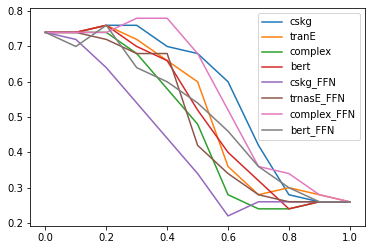

In [36]:
y_=[round(_/10,1) for _ in list(range(11))]
plt.plot(y_, cskgs, label="cskg")
plt.plot(y_, tranEs, label="tranE")
plt.plot(y_, complexs, label="complex")
plt.plot(y_, berts, label="bert")
plt.plot(y_, cskgFFNs, label="cskg_FFN")
plt.plot(y_, transEFFNs, label="trnasE_FFN")
plt.plot(y_, complexFFNs, label="complex_FFN")
plt.plot(y_, bertFFNs, label="bert_FFN")
plt.legend(loc="upper right")
plt.show()

In [37]:
cskgs

[0.74, 0.74, 0.76, 0.76, 0.7, 0.68, 0.6, 0.42, 0.28, 0.26, 0.26]

## case 1
I went to the Y. There was a X but it had no Z. Am I disappointed?

In [38]:
# data file location
case1_cskg_file="./Output/case1_cskg.txt"
case1_bert_file="./Output/case1_bert.txt"
case1_tranE_file="./Output/case1_tranE.txt"
case1_complex_file="./Output/case1_complex.txt"

case1_cskgFFN_file="./Output/case1_cskg_FFN.txt"
case1_bertFFN_file="./Output/case1_bert_FFN.txt"
case1_tranEFFN_file="./Output/case1_tranE_FFN.txt"
case1_complexFFN_file="./Output/case1_complex_FFN.txt"

case1_ground="./ground/case1_ground.tsv"

In [ ]:
%%bash
kgtk query --debug -i cskg_renamed.tsv.gz --match '(z)-[:`/r/AtLocation`]->(x)-[:`/r/AtLocation`]->(y)' --return 'z as needed, x as place, y as Y' -o case1_1.gz

In [ ]:
# load kgtk file
f=gzip.open("case1_1.gz")

head_case1=f.readline()
content_case1=[]
for line in f:
    content_case1.append(line.strip().decode("utf-8").split("\t"))

In [ ]:
# remove duplicate
# content line format: [z, x, y]
content_case1_set=set()

for line in content_case1:
    z,x,y=line
    
    if (z,x,y) not in content_case1_set and (z,x,y) not in content_case1_set:
        content_case1_set.add((z,x,y))

In [ ]:
# before removing
print(f"Number of lines: {len(content_case1)}")
# after removing
print(f"Number of lines after removing duplicate: {len(content_case1_set)}")

In [ ]:
# from content obtain the frequency of each location
loc_distribution=dict()
for line in content_case1_set:
    location=line[2]
    
    loc_distribution[location]=loc_distribution.get(location,0)+1

print("Number of location type:", len(loc_distribution))

# only choose top 100 locations
num_loc=100
print("Number of chosen location:", num_loc)
loc_sort=sorted(loc_distribution.items(),key=lambda k:k[1], reverse=True)
loc_chosen=set([_[0] for _ in loc_sort[:num_loc]])

# filter contenct by loc_chosen
new_content_case1=[]

for line in tqdm(content_case1):
    location=line[2]
    if location in loc_chosen:
        new_content_case1.append(line)

In [ ]:
print(f"Number of lines for all locations: {len(content_case1_set)}")
print(f"Number of lines for top 100 locations: {len(new_content_case1)}")

In [ ]:
# I went to the {y_label}. There was a {x_label} but it had no {z_label}. Am I disappointed?
# filter by sentiment analysis and cosine similarity

"""
Output:
filter_content_case1: filtered x,y,z id, [[z1,x1,y1],[z2,x2,y2],[z3,x3,y3]] 
loc_line:{location_id:[sentence,
                        node bert embedding similarity,
                        tranE Embedding similarity,
                        complex embedding similarity,
                        z label name,
                        x label name]}
"""
filter_content_case1=[]
loc_line=defaultdict(set)

for line in tqdm(new_content_case1):
    z_label=cskg_renamed_dist[line[0]]
    x_label=cskg_renamed_dist[line[1]]
    y_label=cskg_renamed_dist[line[2]]
    if z_label==x_label:
        continue
    x_tokens=text2token(x_label)
    tokens=text2token(z_label)
    sent=f"I went to the {y_label}. There was a {x_label} but it had no {z_label}. Am I disappointed?"
    
    polar=sia.polarity_scores(z_label)
    if polar['neg']>0:
        continue
    polar=sia.polarity_scores(x_label)
    if polar["neg"]>0:
        continue
    
    if x_label in blacklist_label:
        continue
        
    if [_.lemma_ for _ in x_tokens]==[_.lemma_ for _ in tokens]:
        continue
    
    cosine_sim=synsets_cosine_sim(z_label,x_label)
    if cosine_sim>=0.9:
        continue
    
    z_embed_transE=cskg_tranE_embedding[line[0]]
    x_embed_transE=cskg_tranE_embedding[line[1]]
    
    z_embed_complex=cskg_complex_embedding[line[0]]
    x_embed_complex=cskg_complex_embedding[line[1]]
    
    # calculate the cosine similarity between z and y
    z_embed=np.array(eval("["+cskg_word_embeddings[line[0]]+"]"))
    x_embed=np.array(eval("["+cskg_word_embeddings[line[1]]+"]"))
    cskg_similar=cosine_similar(z_embed,x_embed)
    tranE_similar=cosine_similar(z_embed_transE,x_embed_transE)
    complex_similar=cosine_similar(z_embed_complex,x_embed_complex)
    
    
    temp=loc_line[line[2]]
    temp.add((sent,cskg_similar,tranE_similar,complex_similar,z_label,x_label))
    loc_line[line[2]]=temp
    
    filter_content_case1.append(line)

In [ ]:
print(f"Number of lines before filter: {len(new_content_case1)}")
print(f"Number of lines after filter: {len(filter_content_case1)}")

In [ ]:
# add bert embedding into loc_sents
"""
Output:
filter_content_case1: filtered x,y,z id, [[z1,x1,y1],[z2,x2,y2],[z3,x3,y3]] 
loc_line:{location_id:[sentence,
                        node bert embedding similarity,
                        tranE Embedding similarity,
                        complex embedding similarity,
                        sentence transformer embedding similarity,
                        z label name,
                        x label name]}
"""
total=0
loc_sents=dict()
for loc in tqdm(loc_line):
    loc_sents[loc]=list(loc_line[loc])
    total+=len(loc_sents[loc])
    # use bert embedding
    
    z_labels=[]
    x_labels=[]
    
    for tmp in loc_sents[loc]:
        _,_,_,_,z_label,x_label=tmp
        z_labels.append(z_label)
        x_labels.append(x_label)
        
    z_labels_embedding=model.encode(z_labels)
    x_labels_embedding=model.encode(x_labels)
    
    for idx in range(len(loc_sents[loc])):
        z_embed=z_labels_embedding[idx]
        x_embed=x_labels_embedding[idx]
        similar=cosine_similar(z_embed,x_embed)
        
        sent,cskg_embed,tranE_similar,complex_similar,z_label,x_label=loc_sents[loc][idx]
        loc_sents[loc][idx]=(sent,cskg_embed,tranE_similar,complex_similar,similar,z_label,x_label)

In [ ]:
# write result into desk
with open(case1_cskg_file,"w") as f1, open(case1_bert_file,"w") as f4, open(case1_tranE_file,"w") as f2, open(case1_complex_file,"w") as f3:
    sents_count=0
    for loc in loc_sents:
        lines=loc_sents[loc]

        sents_count+=len(lines)
        cskg_lines=[_[0] for _ in sorted(lines,key=lambda k:k[1], reverse=True)]
        transE_lines=[_[0] for _ in sorted(lines,key=lambda k:k[2], reverse=True)]
        complex_lines=[_[0] for _ in sorted(lines,key=lambda k:k[3], reverse=True)]
        bert_lines=[_[0] for _ in sorted(lines,key=lambda k:k[4], reverse=True)]
        
        f1.write("###################################\n")
        f1.write(f"location name: {loc}\n")
        for sent in cskg_lines:
            f1.write(sent+"\n")
        
        f2.write("###################################\n")
        f2.write(f"location name: {loc}\n")
        for sent in transE_lines:
            f2.write(sent+"\n")
            
        f3.write("###################################\n")
        f3.write(f"location name: {loc}\n")
        for sent in complex_lines:
            f3.write(sent+"\n")
            
        f4.write("###################################\n")
        f4.write(f"location name: {loc}\n")
        for sent in bert_lines:
            f4.write(sent+"\n")

In [ ]:
sents_count

## Case3
There was `X` in the `Y`. What can it do to the `Z1n`? `Z1v` it.

In [39]:
# data file location
case3_cskg_file="./Output/case3_cskg.txt"
case3_bert_file="./Output/case3_bert.txt"
case3_tranE_file="./Output/case3_tranE.txt"
case3_complex_file="./Output/case3_complex.txt"

case3_cskgFFN_file="./Output/case3_cskg_FFN.txt"
case3_bertFFN_file="./Output/case3_bert_FFN.txt"
case3_tranEFFN_file="./Output/case3_tranE_FFN.txt"
case3_complexFFN_file="./Output/case3_complex_FFN.txt"

case3_ground="./ground/case3_ground.tsv"

In [ ]:
%%bash
kgtk query --debug -i cskg_renamed.tsv.gz --match '(z)<-[:`/r/UsedFor`]-(x)-[:`/r/AtLocation`]->(y)' --return 'z as needed, x as place, y as Y' -o case3_2.gz
kgtk query --debug -i cskg_renamed.tsv.gz --match '(z)<-[:`/r/CapableOf`]-(x)-[:`/r/AtLocation`]->(y)' --return 'z as needed, x as place, y as Y' -o case3_1.gz

In [40]:
# load kgtk file
f=gzip.open("case3_1.gz")

head_case1=f.readline()
content_case3=[]
for line in f:
    content_case3.append(line.strip().decode("utf-8").split("\t"))
    
f=gzip.open("case3_2.gz")

head_case1=f.readline()
content_case3=[]
for line in f:
    content_case3.append(line.strip().decode("utf-8").split("\t"))

In [41]:
# remove duplicate
# content line format: [z, x, y]
content_case3_set=set()

for line in content_case3:
    z,x,y=line
    
    if (z,x,y) not in content_case3_set and (z,x,y) not in content_case3_set:
        content_case3_set.add((z,x,y))

In [42]:
# before removing
print(f"Number of lines: {len(content_case3)}")
# after removing
print(f"Number of lines after removing duplicate: {len(content_case3_set)}")

Number of lines: 214878
Number of lines after removing duplicate: 214878


In [43]:
# from content obtain the frequency of each location
loc_distribution=dict()
for line in content_case3:
    location=line[2]
    
    loc_distribution[location]=loc_distribution.get(location,0)+1

print("Number of location type:", len(loc_distribution))

# only choose top 100 locations
num_loc=100
print("Number of chosen location:", num_loc)    

loc_sort=sorted(loc_distribution.items(),key=lambda k:k[1], reverse=True)
loc_chosen=set([_[0] for _ in loc_sort[:num_loc]])

Number of location type: 5166
Number of chosen location: 100


In [44]:
# filter contenct by loc_chosen
new_content_case3=[]

for line in tqdm(content_case3_set):
    location=line[2]
    if location in loc_chosen:
        new_content_case3.append(line)

100%|██████████| 214878/214878 [00:00<00:00, 1138826.22it/s]


In [45]:
print(f"Number of lines for all locations: {len(content_case3_set)}")
print(f"Number of lines for top 100 locations: {len(new_content_case3)}")

Number of lines for all locations: 214878
Number of lines for top 100 locations: 69509


In [46]:
# filter content
# z as plan, c as alt, x as goal, y as loc
"""
Output:
loc_line:{location_id:[sentence,
                        node bert embedding similarity,
                        tranE Embedding similarity,
                        complex embedding similarity,
                        y label name,
                        z label name]}
"""
loc_line_case3=defaultdict(set)
for i in tqdm(range(len(new_content_case3))):
    line=new_content_case3[i]
    
    y_id=line[2]
    x_id=line[1]
    z_id=line[0]
    x_label=cskg_renamed_dist[x_id]
    y_label=cskg_renamed_dist[y_id]
    z_label=cskg_renamed_dist[z_id]
    # filter line by X, POS should be (verb)
    z_tokens=text2token(z_label)
    
    if len(z_tokens)<2:
        continue
    else:
        zv=z_tokens[0]
        zn_tokens=z_tokens[1:]
        
        y_embed=np.array(eval("["+cskg_word_embeddings[y_id]+"]"))
        zn_text=" ".join([_.lemma_ for _ in zn_tokens])
        zn_id="/c/en/"+zn_text.replace(" ","_")
        
        # find embed.
        z_embed=np.array(eval("["+cskg_word_embeddings[z_id]+"]"))
        
        z_embed_transE=cskg_tranE_embedding[line[0]]
        y_embed_transE=cskg_tranE_embedding[line[1]]

        z_embed_complex=cskg_complex_embedding[line[0]]
        y_embed_complex=cskg_complex_embedding[line[1]]
        
        cskg_similar=cosine_similar(z_embed,y_embed)
        tranE_similar=cosine_similar(z_embed_transE,y_embed_transE)
        complex_similar=cosine_similar(z_embed_complex,y_embed_complex)
        
        # remove item in blacklist
        if x_label in blacklist_label or zn_text in blacklist_label:
            continue
        
        # remove same item
        if x_label==zn_text:
            continue
            
        # only verb noun structure are allowed
        if zv.pos_ == "VERB" and all([_.pos_=="NOUN" for _ in zn_tokens]):
            
            temp=loc_line_case3[y_id]
            sent=f"There was {x_label} in the {y_label}. What can it do to the {zn_text}? {zv.lemma_} it."
            temp.add((sent,cskg_similar,tranE_similar,complex_similar,y_label,z_label))
            loc_line_case3[y_id]=temp
        else:
            continue

100%|██████████| 69509/69509 [46:13<00:00, 25.06it/s]  


In [47]:
"""
Output:
loc_line:{location_id:[sentence,
                        node bert embedding similarity,
                        tranE Embedding similarity,
                        complex embedding similarity,
                        sentence transformer embedding similarity,
                        y label name,
                        z label name]}
"""
total=0
loc_sents=dict()
for loc in tqdm(loc_line_case3):
    loc_sents[loc]=list(loc_line_case3[loc])
    total+=len(loc_sents[loc])
    # use bert embedding
    
    z_labels=[]
    y_labels=[]
    
    for tmp in loc_sents[loc]:
        _,_,_,_,y_label,z_label=tmp
        z_labels.append(z_label)
        y_labels.append(y_label)
        
    z_labels_embedding=model.encode(z_labels)
    y_labels_embedding=model.encode(y_labels)
    
    for idx in range(len(loc_sents[loc])):
        z_embed=z_labels_embedding[idx]
        y_embed=y_labels_embedding[idx]
        similar=cosine_similar(z_embed,y_embed)
        
        sent,cskg_embed,tranE_similar,complex_similar,z_label,y_label=loc_sents[loc][idx]
        loc_sents[loc][idx]=(sent,cskg_embed,tranE_similar,complex_similar,similar,z_label,y_label)

100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


In [48]:
total

14696

In [49]:
with open(case3_cskg_file,"w") as f1, open(case3_bert_file,"w") as f4, open(case3_tranE_file,"w") as f2, open(case3_complex_file,"w") as f3:
    sents_count=0
    for loc in loc_sents:
        lines=loc_sents[loc]

        sents_count+=len(lines)
        cskg_lines=[_[0] for _ in sorted(lines,key=lambda k:k[1], reverse=True)]
        transE_lines=[_[0] for _ in sorted(lines,key=lambda k:k[2], reverse=True)]
        complex_lines=[_[0] for _ in sorted(lines,key=lambda k:k[3], reverse=True)]
        bert_lines=[_[0] for _ in sorted(lines,key=lambda k:k[4], reverse=True)]
        
        f1.write("###################################\n")
        f1.write(f"location name: {loc}\n")
        for sent in cskg_lines:
            f1.write(sent+"\n")
        
        f2.write("###################################\n")
        f2.write(f"location name: {loc}\n")
        for sent in transE_lines:
            f2.write(sent+"\n")
            
        f3.write("###################################\n")
        f3.write(f"location name: {loc}\n")
        for sent in complex_lines:
            f3.write(sent+"\n")
            
        f4.write("###################################\n")
        f4.write(f"location name: {loc}\n")
        for sent in bert_lines:
            f4.write(sent+"\n")

In [50]:
sents_count

14696